In [1]:
import sys
sys.path.insert(0, '../')
from functions import *

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Random Seed for dataset generation
sampling_seed = 15
torch.manual_seed(sampling_seed)

In [2]:
data = pd.read_table('TrainingData.txt', delimiter=' ', dtype='float', header=None)
data = np.array(data.iloc[:,:])
datam = pd.read_table('MeasuredData.txt', delimiter=' ', dtype='float', header=None)
datam = np.array(datam.iloc[:,:])

perc = 0

data_norm = np.zeros((data.shape), dtype='float')
data_mean = np.zeros((8,2), dtype='float')
data_std = np.zeros((8,2), dtype='float')
for i in range(data_mean.shape[0]):
    k = 0
    for j in [0,2]:
        data_mean[i,k] = data[128*i:128*(i+1),j].mean()
        data_std[i,k] = data[128*i:128*(i+1),j].std()
        data_norm[128*i:128*(i+1),j] = (data[128*i:128*(i+1),j] - data_mean[i,k])/data_std[i,k]
        k += 1
data_norm[:,1] = (data[:,1]-data[:,1].mean())/data[:,1].std()

datam_norm = np.zeros((datam.shape), dtype='float')
datam_mean = np.zeros(2, dtype='float')
datam_std = np.zeros(2, dtype='float')
for j in range(datam.shape[1]):
    datam_mean[j] = datam[:,j].mean()
    datam_std[j] = datam[:,j].std()
    datam_norm[:,j] = (datam[:,j] - datam_mean[j])/datam_std[j]

In [3]:
batch_size = int(data_norm.shape[0]/1)
retrain = 128
n_epochs_1 = 1800
training = DataLoader(torch.utils.data.TensorDataset(torch.tensor(data[:,:2]), torch.tensor(data[:,2])), batch_size=batch_size, shuffle=True)
my_network_1 = NeuralNet_Seq(input_dimension=2, output_dimension=1, n_hidden_layers=4, neurons=20)
init_xavier(my_network_1, retrain + np.random.randint(-retrain,retrain))
optimizer = optim.LBFGS(my_network_1.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
if perc == 0:
    history = fit(my_network_1, training, n_epochs_1, optimizer, p=2, reg_param=0.0, verbose=False)
else:
    history = fit_k(my_network_1, training, torch.tensor(data_val[:2]), torch.tensor(data_val[:,2]), n_epochs_1, optimizer, p=2, reg_param=0.0, verbose=False)

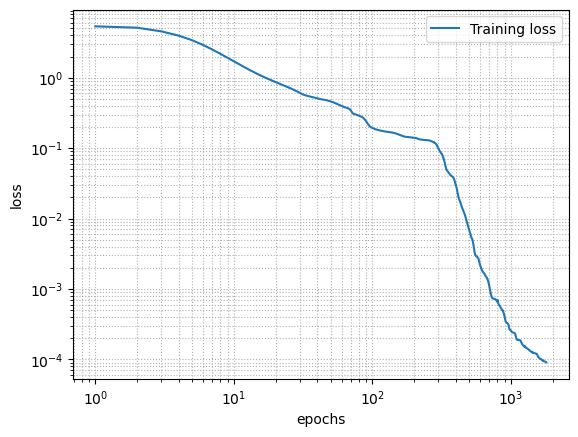

In [4]:
plt.figure()
plt.grid(True, which="both", ls=":")
if perc == 0:
    plt.plot(np.arange(1,n_epochs_1+1), history, label='Training loss')
else:
    plt.plot(np.arange(1,n_epochs_1+1), history[0], label='Training loss')
    plt.plot(np.arange(1,n_epochs_1+1), history[1], label='Validation loss')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [5]:
G = lambda x: sp.linalg.norm(my_network_1(torch.tensor(np.concatenate((datam[:,0].reshape(-1,1),np.ones((datam.shape[0],1))*x),axis=1)).float()).detach().numpy()-datam[:,1].reshape(-1,1))
ff = sp.optimize.minimize_scalar(G, bounds=(min(data[:,1]),max(data[:,1])), method='bounded')
df = pd.DataFrame(np.array([ff.x]))
df.to_csv('Task4.txt', header = False, index = None)

uf = np.linspace(min(data[:,1]),max(data[:,1]),500)
G = np.zeros(uf.shape, dtype='float')
G_min = 1e4
u_min = 0

for i in range(len(uf)):
    pred = my_network_1(torch.tensor(np.concatenate((datam[:,0].reshape(-1,1),np.ones((datam.shape[0],1))*uf[i]),axis=1)).float()).detach().numpy()
    G[i] = np.linalg.norm(pred-datam[:,1])
    if G[i] < G_min:
        G_min = G[i]
        u_min = uf[i]

plt.figure()
#plt.scatter(uf*data[:,1].std()+data[:,1].mean(),G, s=4)
plt.scatter(uf,G, s=4)
#plt.title('$u_f^* =$' + str(u_min*data[:,1].std()+data[:,1].mean()))
plt.title('$u_f^* =$' + str(u_min))
plt.show()

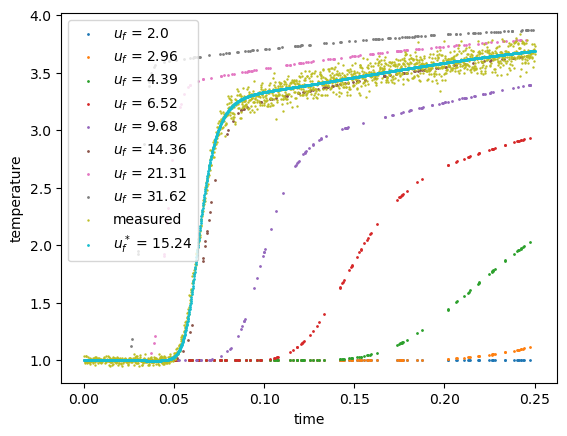

In [6]:
# Verification

u = pd.read_table('Task4.txt', dtype='float', header=None)
u = np.array(u)[0,0]

i = 0
plt.figure()
while i < data.shape[0]:
    plt.scatter(data[i:i+128,0],data[i:i+128,2], s=1, label='$u_f$ = '+str(round(data[i,1],2)))
    i+=128
plt.scatter(datam[:,0],datam[:,1],s=0.5, label='measured')
kk = my_network_1(torch.tensor(np.concatenate((datam[:,0].reshape(-1,1),np.ones((datam.shape[0],1))*u),axis=1)).float()).detach().numpy()
#plt.scatter(datam[:,0],kk*datam_std[1]+datam_mean[1],s=1, label='$u_f^*$ = '+str(round(u*data[:,1].std()+data[:,1].mean(),2)))
plt.scatter(datam[:,0],kk,s=1, label='$u_f^*$ = '+str(round(u,2)))
plt.legend()
plt.xlabel('time')
plt.ylabel('temperature')
plt.show()